In [1]:
from VisionEngine.datasets import guppies
from VisionEngine.utils.config import process_config
from VisionEngine.utils import factory
import sys
import os
from PIL import Image
from itertools import product
from dotenv import load_dotenv
from pathlib import Path

import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
pwd

'/home/etheredge/Workspace/VisionEngine/notebooks'

In [3]:
checkpoint_path = '/home/etheredge/Workspace/VisionEngine/checkpoints/guppy_periodic/2020-213-11/guppy_periodic.hdf5'

In [4]:
config_file = '/home/etheredge/Workspace/VisionEngine/VisionEngine/configs/guppy_periodic_config.json'
config = process_config(config_file)

In [5]:
env_path = Path('../') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [6]:
model = factory.create(
            "VisionEngine.models."+config.model.name
            )(config)

importing VisionEngine.models.vae_model
getattr VAEModel
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 32), (None,  38380171    input_2[0][0]                    
__________________________________________________________________________________________________
dense_siren (DenseSiren)        (None, 10)           330         encoder[1][0]                    
__________________________________________________________________________________________________
dense_siren_2 (DenseSiren)      (None, 10)        

In [7]:
model.load(checkpoint_path)

Loading model checkpoint /home/etheredge/Workspace/VisionEngine/checkpoints/guppy_periodic/2020-213-11/guppy_periodic.hdf5 ...

Model loaded


In [8]:
# config.data_loader.use_generated = True
# config.data_loader.use_real = False

In [9]:
data_loader = factory.create(
            "VisionEngine.data_loaders."+config.data_loader.name
            )(config)

importing VisionEngine.data_loaders.vae_data_loader
getattr DataLoader


In [10]:
def plot_im(img):
    if config.model.last_activation == 'tanh':
        img * 0.5 + 0.5
        return img
    else:
        return img

def plot_img_attributions(image,
                          attribution_mask,
                          H=0,
                          z_i=0,
                          cmap=None,
                          overlay_alpha=0.4):

    fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(12, 4))

    axs[0, 1].set_title('Original sample Output')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[0, 2].set_title(f'Attribution mask: {H}, {z_i}')
    axs[0, 2].imshow(attribution_mask, cmap=cmap)
    axs[0, 2].axis('off')

    axs[0, 3].set_title(f'Overlay: {H}, {z_i}')
    axs[0, 3].imshow(attribution_mask, cmap=cmap)
    axs[0, 3].imshow(image, alpha=overlay_alpha)
    axs[0, 3].axis('off')

    plt.tight_layout()
    return fig

def plot_overlay(image,
                 attribution_mask,
                 H=0,
                 z_i=0,
                 cmap=None,
                 overlay_alpha=0.4):

    fig, axs = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(4, 4))
    axs[0, 0].set_title(f'Overlay: {H}, {z_i}')
    axs[0, 0].imshow(attribution_mask, cmap=cmap)
    axs[0, 0].imshow(image, alpha=overlay_alpha)
    axs[0, 0].axis('off')
    plt.tight_layout()
    return fig

In [11]:
def embed_images(x):
    outputs = [
        model.model.get_layer('normal_variational').output,
        model.model.get_layer('normal_variational_1').output,
        model.model.get_layer('normal_variational_2').output,
        model.model.get_layer('normal_variational_3').output
    ]
    encoder = tf.keras.Model(model.model.inputs, outputs)
    return encoder.predict(x)

def reconstruct_images(x):
    return model.model.predict(x)

In [12]:
# encode the samples
x = data_loader.get_train_data().shuffle(1000).take(1)
z = tf.convert_to_tensor(embed_images(x))

# get the original samples reconstruction
x_hat = reconstruct_images(x)

In [13]:
list(x)[0][0].shape

TensorShape([16, 256, 256, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


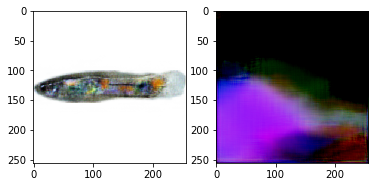

In [14]:
sample_id = 8  # < 16 we're only grabbing one batch at a time
plt.subplot(121)
plt.imshow(list(x)[0][0][sample_id])
plt.subplot(122)
plt.imshow(x_hat[sample_id])

In [15]:
hierarchical_level = 3
encoding_axis = 0

In [52]:
z = tf.convert_to_tensor(z)

In [33]:
decoder = model.model.get_layer('decoder')

In [46]:
 ims = decoder([z[0], z[1], z[2], z[3]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


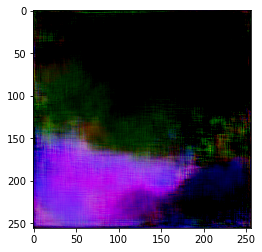

In [47]:
plt.imshow(ims[6])

In [48]:
with tf.GradientTape() as tape:
    tape.watch([z[0], z[1], z[2], z[3]])
    ims = decoder([z[0], z[1], z[2], z[3]])
grads = tape.gradient(ims,[z[0], z[1], z[2], z[3]] )

In [207]:
model.decoder_inputs

[<tf.Tensor 'z_1:0' shape=(None, 10) dtype=float32>,
 <tf.Tensor 'z_2:0' shape=(None, 10) dtype=float32>,
 <tf.Tensor 'z_3:0' shape=(None, 10) dtype=float32>,
 <tf.Tensor 'z_4:0' shape=(None, 10) dtype=float32>]

In [221]:
def interpolate_latentvar(Z, H, z_i, alphas, zdim=10):
    mods = []
    for h in range(len(Z)):
        if h == H:
            z = Z[h]
            mod = tf.concat([
                tf.repeat(
                    [z], 10, axis=0)[:,-1:z_i],
                alphas[:, tf.newaxis],
                tf.repeat(
                    [z], 10, axis=0)[:, z_i:-1]], axis=1)
            mods.append(mod)
        else:
            z = Z[h]
            mod = tf.repeat([z], 10, axis=0)
            mods.append(mod)

    return mods

def compute_gradients(latent_vars):
    with tf.GradientTape() as tape:
        images = model.decoder([latent_vars[0], latent_vars[1], latent_vars[2], latent_vars[3]])
    return tape.gradient(images,model.decoder.variables)


def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients


# @tf.function
def integrated_gradients(encoding, H=0, z_i=0, m_steps=300, batch_size=10, lim=1.):

    # Generate traversal steps
    traversal_steps = tf.linspace(start=0.0, stop=lim, num=m_steps)
    

    # Accumulate gradients across batches
    integrated_gradients = 0.0

    # Batch traversals
    ds = tf.data.Dataset.from_tensor_slices(traversal_steps).batch(batch_size)

    for batch in ds:
        batch_interpolated_inputs = interpolate_latentvar(Z=encoding, H=H, z_i=z_i, alphas=batch)
        batch_gradients = compute_gradients(batch_interpolated_inputs)
        return batch_gradients
        integrated_gradients += integral_approximation(gradients=batch_gradients)
    
    return tf.abs(lim) * integrated_gradients

In [224]:
for att in attributions:
    try:
        print(att.shape)
    except AttributeError:
        print(att)

(10, 524288)
(524288,)
(10, 524288)
(524288,)
(3, 3, 2048, 2048)
(2048,)
None
None
(2048,)
(2048,)
None
None
(3, 3, 2048, 1024)
(1024,)
None
None
(1024,)
(1024,)
None
None
(3, 3, 1024, 1024)
(1024,)
None
None
(1024,)
(1024,)
None
None
(3, 3, 1024, 512)
(512,)
None
None
(512,)
(512,)
None
None
(10, 524288)
(524288,)
(3, 3, 512, 512)
(512,)
None
None
(512,)
(512,)
None
None
(3, 3, 512, 256)
(256,)
None
None
(256,)
(256,)
None
None
(3, 3, 256, 256)
(256,)
None
None
(256,)
(256,)
None
None
(3, 3, 256, 128)
(128,)
None
None
(128,)
(128,)
None
None
(10, 524288)
(524288,)
(3, 3, 128, 128)
(128,)
None
None
(128,)
(128,)
None
None
(3, 3, 128, 64)
(64,)
None
None
(64,)
(64,)
None
None
(3, 3, 64, 64)
(64,)
None
None
(64,)
(64,)
None
None
(3, 3, 64, 32)
(32,)
None
None
(32,)
(32,)
None
None
(3, 3, 32, 32)
(32,)
None
None
(32,)
(32,)
None
None
(3, 3, 32, 16)
(16,)
None
None
(16,)
(16,)
None
None
(3, 3, 16, 16)
(16,)
None
None
(16,)
(16,)
None
None
(3, 3, 16, 8)
(8,)
None
None
(8,)
(8,)
None
None
(3

In [223]:
# compute atributions by integrating the gradients
attributions = integrated_gradients(z[:,sample_id,:], H=hierarchical_level, z_i=encoding_axis)

# visualize the attributions
attributions_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

_ = plot_img_attributions(image=x_hat[sample_id],
                          attribution_mask=attributions_mask,
                          H=hierarchical_level,
                          z_i=encoding_axis,
                          cmap=plt.cmap.vridis,
                          overlay_alpha=0.4)


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.